In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
corona = pd.read_excel("./고로나_수정.xlsx", sheet_name='고로나')

In [3]:
corona.set_index('Unnamed: 0', inplace=True)

In [4]:
고로나 = corona.loc['2020-02-01' : '2020-05-31'].copy()

In [5]:
고로나

,신규확진,지역확진,해외유입,누계,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
Unnamed: 0,,,,,,,,,,
2020-02-01,5.0,4.0,1.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,3.0,1.0,2.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,0.0,0.0,0.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,1.0,0.0,1.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,2.0,1.0,1.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-05-27,40.0,37.0,3.0,11265.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-28,79.0,68.0,11.0,11344.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-29,58.0,55.0,3.0,11402.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 건강한 사람들의 dt
def non_fear(건강인, 감염자, 총인구, 공포감):
    dt_S = (-감염률 * 건강인 * 감염자)/총인구 - 공포감 * 건강인 * (1-np.exp(-전환률*격리환자))
    if 건강인 > 0:
        return round(dt_S,7)
    else:
        return 0

# 건강하지만 두려워서 생활패턴이 바뀐 사람들의 dt
def fear(건강인, 무서운_건강인, 감염자, 총인구, 공포감, 거리두기):
    dt_SF =  공포감 * 건강인 * (1-np.exp(-전환률*격리환자)) - (거리두기 * 감염률 * 무서운_건강인 * 감염자)/총인구
    if dt_SF < 건강인:
        return round(dt_SF,7)
    else:
        return 0

# 잠복기 환자들의 dt
def incubation(건강인, 무서운_건강인, 감염자, 총인구, 거리두기, 잠복환자):
    dt_incu = (감염률 * 건강인 * 감염자)/총인구 + (거리두기 * 감염률 * 무서운_건강인 * 감염자)/총인구 - 잠복환자/잠복기간
    if 잠복환자 < 건강인 + 무서운_건강인:
        return round(dt_incu,7)
    else:
        return 0

# 감염자들의 dt
def infected(잠복환자, 감염자):
    dt_infe = 잠복환자/잠복기간 - 감염자/진단판정
    return round(dt_infe,7)

# 격리자들의 dt
def quarantine(감염자):
    dt_q = 감염자/진단판정 - 회복률 * 격리환자
    return round(dt_q,7)

# 회복된 사람들의 dt
def recoverd():
    dt_R = 회복률 * 격리환자
    return round(dt_R,7)

In [7]:
# 1인당 옮기는 감염자 수
########################### 질병관리본부 정은경 본부장 "2.5~3 사이라고 본다" (4월 10일) #############################################
감염률 = 2.75

# 초기 감염자 수(가정)
감염자 = 1
감염자_지역 = 0

# 초기 잠복환자 수
잠복환자 = 0
잠복환자_지역 = 1

# 지금까지 다 걸린 사람
총감염자 = 감염자 + 잠복환자
총감염자_지역 = 감염자_지역 + 잠복환자_지역

# 초기 격리환자 수
격리환자 = 0
격리환자_지역 = 0

# 원하는 지역의 총 인구(대한민국으로 가정)
총인구 = 51640000
# 명동의 월별 평균 유동인구
지역_인구 = 320000

# 현재 병에 걸릴 위험이 있는 사람들의 수
건강인 = 총인구 - 감염자 - 잠복환자
건강인_지역 = 지역_인구 - 감염자_지역 - 잠복환자_지역

# 질병에 대한 두려움으로 생활패턴이 바뀐 건강한 사람의 수
무서운_건강인 = 0
무서운_건강인_지역 = 0

#############################사회에 공포가 퍼져나가는 정도, 대구가 4.08이었으므로 조금 낮게 가정해보았음 ################
공포감 = 4  
# 대충 명동은 2.4배라고 가정해보자
공포감_지역 = 10

# 환자가 n 명일 때 건강인은 무서운_건강인으로 전환됨
# 논문에서는 환자 1000명 발생 할 때 마다, 한 단위 증가한다고 가정
전환률 = 1/1000

############################### 델타 값 추론하기 ############################### (안되면 1/50 그냥 넣기)

# 전염병의 전염률을 낮추는 각종 요인들의 합
# 여기서는 사회적 거리두기로 통칭
# 거리두기 : WHO 논문에서 마스크를 쓰면 4.92배 감소, 1m 이상 떨어지면 5.61배 감소
# 12,000명 중에 대한민국 정부가 사전에 발견한 잠복기 환자는 약 4000명 따라서 약 1.5배 감소 효과가 있었을 것
# 4.92 * 5.61 * 1.5 = 41.4018 약 41.4로 가정
거리두기 = 1/41.4
거리두기_지역 = 1/20

################################################################################

# 병에 걸렸다고 회복되는 비율(투병기간 약 14일 이므로, 단순하게 1/14로 가정[논문])
회복률 = 1/14

# 코로나 바이러스 평균 잠복기간
# 질병관리본부 3월 발표자료 인용 (추가 조사 밑 반영되면 좋음)
잠복기간 = 4.1

# 코로나 증상 발현 후, 진단/격리까지 소요되는 시간
진단판정 = 4.6

# 회복한 환자
회복환자 = 0

scatt = []
mask = []

for i in range(0,120):
    scatt.append([i,감염자])
    mask.append(무서운_건강인)
    건강인_df = non_fear(건강인, 감염자, 총인구, 공포감)
    무서운_건강인_df = fear(건강인, 무서운_건강인, 감염자, 총인구, 공포감, 거리두기)
    잠복환자_df = incubation(건강인, 무서운_건강인, 감염자, 총인구, 거리두기, 잠복환자)
    감염자_df = infected(잠복환자, 감염자)
    격리환자_df = quarantine(감염자)
    회복환자_df = recoverd()
    
    건강인 += 건강인_df
    무서운_건강인 += 무서운_건강인_df
    잠복환자 += 잠복환자_df
    감염자 += 감염자_df
    격리환자 += 격리환자_df
    회복환자 += 회복환자_df
    총감염자 += 감염자
    if i >= 9:
        건강인_지역_df = non_fear(건강인_지역, 감염자_지역, 지역_인구, 공포감_지역)
        무서운_건강인_지역_df = fear(건강인_지역, 무서운_건강인_지역, 감염자_지역, 지역_인구, 공포감_지역, 거리두기_지역)
        잠복환자_지역_df = incubation(건강인_지역, 무서운_건강인_지역, 감염자_지역, 지역_인구, 거리두기_지역, 잠복환자_지역)
        감염자_df = infected(잠복환자_지역, 감염자_지역)
        
        건강인_지역 += 건강인_지역_df
        무서운_건강인_지역 += 무서운_건강인_지역_df
        잠복환자_지역 += 잠복환자_지역_df
        감염자_지역 += 감염자_df
    print(감염자)    
print('-------------------------------------------------------------------')
print(총감염자)

0.7826086999999999
1.2832081
2.0363088
3.2339283
5.1338003
8.1446415
12.907840400000001
20.4224065
32.2251496
50.6325111
79.01899610000001
122.01758690000001
185.32108190000002
274.390847
390.9998044
527.0844418
659.0868453
753.2132526
789.5059216000001
779.7444096
743.7134793
693.8544739
637.89029
580.5233340000001
524.5317100000001
471.47551390000007
422.1509523000001
376.8815939000001
335.7045603000001
298.4890220000001
265.01112990000007
235.00095340000007
208.17146960000008
184.23607820000007
162.91881320000007
143.95993670000007
127.11864020000007
112.17396150000008
98.92462450000008
87.18825350000007
76.80024730000008
67.61249140000008
59.49201920000008
52.31968890000008
45.98891350000008
40.40446640000008
35.48137170000008
31.143882000000083
27.32454340000008
23.96334370000008
21.00693900000008
18.40795350000008
16.12434710000008
14.118844700000079
12.358422500000078
10.813846000000078
9.459254700000077
8.271790100000077
7.231261600000077
6.319848200000077
5.522127200000077
4.8

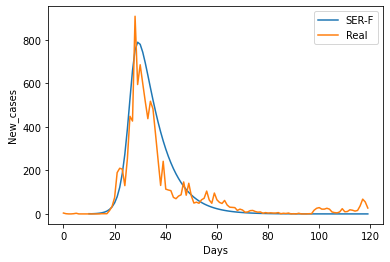

In [8]:
plt.plot([scatt[i][0] for i in range(10,120)], [scatt[i][1] for i in range(0,110)])
plt.plot([i for i in range(0,120)], [고로나.지역확진[i] for i in range(0,120)])
plt.xlabel('Days')
plt.ylabel('New_cases')
plt.legend(['SER-F', 'Real'])

Text(0, 0.5, '착용자 숫자')

C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 52265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49707 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 52265 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\JIN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50857 missing from current font.
 

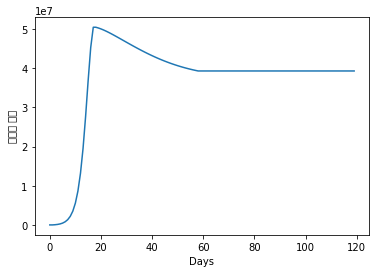

In [9]:
plt.plot([i for i in range(0,120)], [mask[i] for i in range(0,120)])
plt.xlabel('Days')
plt.ylabel('착용자 숫자')